<a href="https://colab.research.google.com/github/IUT-Thesis-Group-Cmr/ML-Project/blob/master/ML_Project_Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization tweaks**
* Initiating GoogleDrive mounting
* Necessary Library's imports
* Load Dataset [**Optional**]


In [50]:
#-Google Drive Access-Granting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# files paths
path = '/content/drive/My Drive/ThesisFile/datasets/ml-project/fake_real-news-dataset/'
if path[-1] != '/':
  path += '/'
print('Good to go ✔')

Good to go ✔


In [52]:
#-Library imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math 
import nltk
import string
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.utils import validation
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, pairwise_distances, mean_absolute_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from seaborn import heatmap
from math import exp
from random import randint, seed
import itertools
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
from collections import deque

%matplotlib inline

In [53]:
def nclass_classification_mosaic_plot(n_classes, results):
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prdiction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]
    ]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)]*2
    mosaic_tuples = tuple(itertools.product(*class_lists))
    
    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t:res_list[i] for i,t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(11, 10))
    plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
    pallet = [
        '#6a89cc', 
        '#4a69bd', 
        '#1e3799', 
        '#0c2461',
        '#82ccdd',
        '#60a3bc',
    ]
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)):{'color':all_colors[i]} for i,(a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ''

    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {
        'fontsize': 20,
        'color' : font_color,
    }
    axis_label_font_dict = {
        'fontsize': 16,
        'color' : font_color,
    }

    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.axes.yaxis.set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=14)

    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [Patch(facecolor=all_colors[i], label='Class {}'.format(i)) for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.018), fontsize=16)

    plt.tight_layout()
    plt.show()

In [54]:
# Loading Dataset
file0 = 'news.csv'
file1 = 'Fake.csv'
file2 = 'True.csv'

df0 = pd.read_csv(path + file0)
df1 = pd.read_csv(path + file1)
df2 = pd.read_csv(path + file2)

print(df0)
print(df1)
print(df2)

df1['label'] = 'FAKE'
df2['label'] = 'TRUE'

dataset = pd.concat([df0[['text','label']] , df1[['text','label']] , df2[['text','label']]], ignore_index=True)

dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.tail()

# print('Dataset Attributes::', dataset.columns)
# print('Dataset Dim::', dataset.shape)
# print(dataset.head())
# print('\nData Output::\n', dataset.label)

      Unnamed: 0  ... label
0           8476  ...  FAKE
1          10294  ...  FAKE
2           3608  ...  REAL
3          10142  ...  FAKE
4            875  ...  REAL
...          ...  ...   ...
6330        4490  ...  REAL
6331        8062  ...  FAKE
6332        8622  ...  FAKE
6333        4021  ...  REAL
6334        4330  ...  REAL

[6335 rows x 4 columns]
                                                   title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                                                  ...  ...                ...
23476  McPain: John McCain Furious That Iran Treated ...  ...   January 

,text,label
51228,Wow! This is really epic! Paris Dennard nails ...,FAKE
51229,It was just a few weeks ago that President-ele...,FAKE
51230,(Reuters) - Co-host of MSNBC’s “Morning Joe” a...,TRUE
51231,,FAKE
51232,Ted Cruz again showed that his campaign is wei...,FAKE


# **Analyzing Dataset**


*   Determining the Labels(outputs) and Inputs



In [55]:
# Outputs or Labels
labels = dataset.label;
print(labels)

# Sample Data
df = dataset['text']
df

0        TRUE
1        REAL
2        FAKE
3        TRUE
4        FAKE
         ... 
51228    FAKE
51229    FAKE
51230    TRUE
51231    FAKE
51232    FAKE
Name: label, Length: 51233, dtype: object


0        TUNIS/ROME (Reuters) - At least eight people d...
1        Donald Trump threatened to sue the New York Ti...
2        David Daleidan, the ringleader for the decepti...
3        WASHINGTON (Reuters) - President Donald Trump ...
4        While so many keep trashing Beyonc  Knowles fo...
                               ...                        
51228    Wow! This is really epic! Paris Dennard nails ...
51229    It was just a few weeks ago that President-ele...
51230    (Reuters) - Co-host of MSNBC’s “Morning Joe” a...
51231                                                     
51232    Ted Cruz again showed that his campaign is wei...
Name: text, Length: 51233, dtype: object

# **Splitting the dataset**

*   Split the dataset into training and testing sets.

In [56]:
# Split Dataset with a 8:2 ratio for training and testing
#         sampple data:: the 'text' column only.
x_train,x_test,y_train,y_test = train_test_split(df, labels, test_size=0.2, 
                                                 random_state=7)
print(x_train)
print(y_train)

6890     MOSCOW (Reuters) - Russian long-range bombers ...
45936    Kentucky governor Matt Bevin recently introduc...
22230    MEXICO CITY (Reuters) - Mexico’s new finance m...
40082    WASHINGTON (Reuters) - U.S. President Donald T...
42905    AT&T sold access to customer data to law enfor...
                               ...                        
13927    Jake Tapper and the new White House Communicat...
919      HAVANA (Reuters) - Boxy Russian-built Lada aut...
38467    Are the most criminal, brazen and crooked grou...
10742    WASHINGTON (Reuters) - Former Democratic presi...
49689    Donate The American Way: Socialism for the Ric...
Name: text, Length: 40986, dtype: object
6890     TRUE
45936    FAKE
22230    TRUE
40082    TRUE
42905    FAKE
         ... 
13927    FAKE
919      TRUE
38467    FAKE
10742    TRUE
49689    FAKE
Name: label, Length: 40986, dtype: object


# **Dataset Preprocessing using a TfidfVectorizer**

Let’s initialize a ***TfidfVectorizer*** with stop words from the English language and a maximum document frequency of 0.7 (terms with a higher document frequency will be discarded). Stop words are the most common words in a language that are to be filtered out before processing the natural language data. And a *TfidfVectorizer* turns a collection of raw documents into a matrix of TF-IDF features.

*  **TF (Term Frequency)**: The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.
*  **IDF (Inverse Document Frequency):** Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

In [57]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

print(tfidf_test)

  (0, 124172)	0.04053855352120491
  (0, 123246)	0.15069794656283786
  (0, 123107)	0.07290641695841663
  (0, 120186)	0.030183964429714924
  (0, 118529)	0.11081057726377773
  (0, 118326)	0.11883997118142754
  (0, 117644)	0.061025681478950176
  (0, 111735)	0.0597998045677675
  (0, 110174)	0.12258206198944771
  (0, 109507)	0.028450590293419797
  (0, 109499)	0.07098770263102244
  (0, 105894)	0.06183975058943655
  (0, 105860)	0.08325798608440355
  (0, 103867)	0.10185826513371071
  (0, 103678)	0.21237690199832282
  (0, 103673)	0.11999768669827554
  (0, 103667)	0.055358690056072905
  (0, 102128)	0.09384155124353367
  (0, 102075)	0.07278232856682879
  (0, 99730)	0.12585109229077263
  (0, 99480)	0.04624808484923598
  (0, 96479)	0.09432636749462692
  (0, 95574)	0.038892499275881044
  (0, 95546)	0.051583709899832894
  (0, 94888)	0.07149473701351795
  :	:
  (10246, 24122)	0.07253001519989351
  (10246, 23883)	0.05251585921876929
  (10246, 21889)	0.04031492954763847
  (10246, 20990)	0.094277526963829

# **Learning Model Selection**

Choose a Learning Model, Methodology or Schema for training the dataset.

Here, as it's a classification problem, we are using a ***PassiveAggressiveClassifier*** due to the fact that we have vectorized the sample data during the preprocessing step using a *TfidfVectorizer*.

For explaination purpose, **Passive Aggressive algorithms** are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [58]:
# Initialize a PassiveAggressiveClassifier
model = PassiveAggressiveClassifier(max_iter=50)
model

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

# **Fitting the Model and Predicting its outcomes.**

Here we will fit the model with the trained vectorized sample data from ```tfidf_train``` of the **TfidfVectorizer** and the ```y_train``` of the initial sample data.

In [59]:
# Fitting the Model with the tfidf_train & y_train.
model.fit(tfidf_train,y_train)

# Predict on the test set tfidf_test from the TfidfVectorizer
y_pred = model.predict(tfidf_test)
print('Predicted Outcomes -->', y_pred, y_pred.shape)

#           and 

# Calculate the accuracy with accuracy_score()
score = accuracy_score(y_test,y_pred)
print(f'\nModel-Accuracy: {round(score*100,2)}%')

Predicted Outcomes --> ['FAKE' 'FAKE' 'TRUE' ... 'REAL' 'TRUE' 'TRUE'] (10247,)

Model-Accuracy: 97.52%


# **Report and Visualization on the selected Model**

From the Previous Step, after training and testing the model using *PassiveAggressiveClassifier* we got an *accuracy* of more than **97%** on the testing sample.

For more insights, we will print out the **confusion matrix** to view the number of false and true negatives and positives.

We will also print out the **heat map** generated from the confusion matrix.


In [60]:
# Model Report
report = classification_report(y_test,y_pred, labels=['FAKE','REAL'])

print('----------------=====Model Report=====----------------\n')
print(report)
print('------------------------------------------------------\n')


# Confusion-Matrix
conf_mat = confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

print('::Confusion-Matrix::')
print('',conf_mat)
print('------------------------------------------------------\n')


# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: \t%.2f\n" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: \t%.2f\n" % metrics.recall_score(y_test, y_pred, average='weighted'))
print('------------------------------------------------------\n')

----------------=====Model Report=====----------------

              precision    recall  f1-score   support

        FAKE       0.97      0.99      0.98      5332
        REAL       0.91      0.77      0.83       638

   micro avg       0.97      0.96      0.97      5970
   macro avg       0.94      0.88      0.91      5970
weighted avg       0.97      0.96      0.96      5970

------------------------------------------------------

::Confusion-Matrix::
 [[5257   40]
 [ 119  489]]
------------------------------------------------------

Precision: 	0.97

Recall: 	0.98

------------------------------------------------------



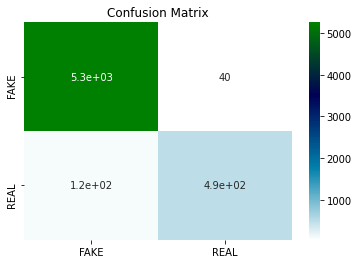

In [61]:
# Visualization of confusion-matrix with a heat-map
# fig = plt.figure(figsize=(10,6))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

sns.heatmap(conf_mat, annot=True, cmap=plt.cm.ocean_r,
            xticklabels=['FAKE','REAL'], 
            yticklabels=['FAKE','REAL'])
plt.show()


<class 'list'> [[5257, 40], [119, 489]]


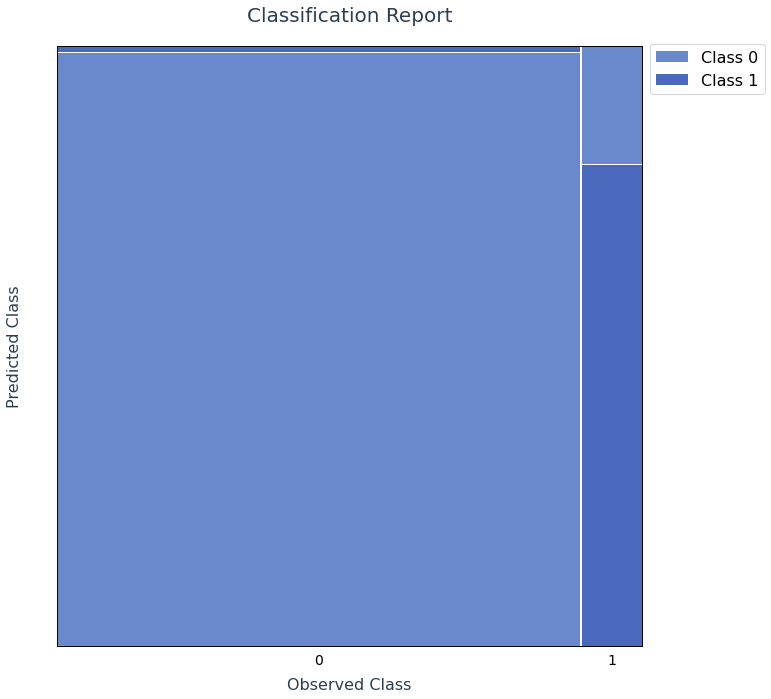

In [64]:
# Converting numpyarray to list
results = list()
for line in conf_mat:
  results.append([data for data in line])
print(type(results), results)

# visualize
nclass_classification_mosaic_plot(len(results), results)